# Bibliometric network analysis & topic modelling

Bibliometric data from academic databases can be used to find relationships between metadata (authors, titles, citations etc.) and discover dominant topics. In this kernel, we'll use the Metaknowledge package and an information science and bibliometrics dataset from Web of Science/scopus to perform network analysis. 

From: https://arxiv.org/ftp/arxiv/papers/2304/2304.14516.pdf

EDA capabilities encompass the tools’ 
capacity for preliminary data analysis, pattern and trend identification, and data visualization, empowering
researchers to uncover insights and formulate hypotheses. Network Analysis capabilities indicate the tools’
proficiency in examining and visualizing intricate relationships among entities such as authors, citations,
and keywords, thereby aiding researchers in deciphering data structure and dynamics. Artificial Intelligence
capabilities utilize Deep Learning techniques, like Topic Modeling, Embedding vectors, Text
Summarization, and General NLP tasks, to augment the tools’ effectiveness.

The most common features these tools share include Citation Analysis, Collaboration Analysis,
and World Collaboration Analysis, with many tools supporting Similarity Analysis and Topic Modeling.
Both pyBibX and Scientopy offer a wide range of features.

Three of the most commonly used scientific databases are WoS, Scopus, and PubMed. While these
databases share similarities in their coverage of scientific literature, they also have unique features that set
them apart. Researchers working in a specific field, such as medicine, may find PubMed the most relevant,
as it covers biomedical literature in-depth. On the other hand, researchers working in interdisciplinary fields
may find WoS or Scopus more valuable, as they cover a broad range of subjects.

We'll try and answer the following questions:

    Which of the top authors are also top co-authors?
    What does the co-authorship network look like?
    What are the dominant topics that emerge from these academic papers?

Other sources: 

https://www.kaggle.com/code/kruttika17/bibliometric-network-analysis-topic-modelling

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


# Libraries

In [1]:
#Requiered libraries
import numpy as np
import pandas as pd
import textwrap
from pyBibX.base import pbx_probe
from prettytable import PrettyTable

C:\Users\cata1\AppData\Local\Temp\ipykernel_16124\871138830.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\cata1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data

In [70]:
#Loading data
# Read data into papers
file_name = 'C:/Users/cata1/OneDrive - University of California, Davis/GEO200E_ResearchDesign/LitReview/scopus.bib'
database = 'savedrecs'
bibfile = pbx_probe(file_bib = file_name, db = database)

A Total of 430 Documents were Found ( 436 Documents and 6 Duplicates )

UNKNOW = 430


# Exploratory Data Analysis

In this section, we will perform EDA on the merged dataset. This essential step in data analysis helps us
understand the data’s underlying structure, patterns, and relationships. Also, this step provides a
comprehensive overview of the merged dataset and enables us to identify key features and trends that may
inform further analysis.

## 1. Statistics related to the collection of documents

In [71]:
# Generate EDA (Exploratory Data Analysis) Report
report = bibfile.eda_bib()

# Check report
report


,Main Information,Results
0,Timespan,2006-2024
1,Total Number of Countries,76
2,Total Number of Institutions,750
3,Total Number of Sources,350
4,Total Number of References,0
5,Total Number of Languages,2
6,--english (# of docs),429
7,--portuguese (# of docs),1
8,-//-,-//-
9,Total Number of Documents,430


In [72]:
# Check Docs IDs
data_ID = pd.DataFrame(bibfile.table_id_doc)
display(data_ID.iloc[:15])

,ID,Document
0,0,"Kabit, Mohamad Raduan and Siong, Jeffery Ting ..."
1,1,"Fan, Fei and Dai, Shangze and Yang, Bo and Ke,..."
2,2,"Chakraborty, Susanta Kumar and Sanyal, Poulomi..."
3,3,"Agyeman, Fredrick Oteng and Zhiqiang, Ma and L..."
4,4,"Lichter, Katie E. and Anderson, Justin and Sim..."
5,5,"Liber, Alex C. (2022). Using Regulatory Stance..."
6,6,"Goods, Caleb and Ellem, Bradon (2023). Employe..."
7,7,"Blackburn, Rebecca and Leviston, Zoe and Walke..."
8,8,"Shah, Yatish T. (2022). Advanced Power Generat..."
9,9,"Dhawan, Kamal and Tookey, John E. and Ghaffari..."


In [73]:
# Check Docs IDs per Type
data_Type = pd.DataFrame(bibfile.id_doc_types())
display(data_Type)

,Document Types,IDs
0,UNKNOW,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [74]:
# Check Authors IDs
data_Authors = pd.DataFrame(bibfile.table_id_aut)
display(data_Authors.iloc[:15])

,ID,Author
0,a_0,"abaker, wafa e.a."
1,a_1,"abalansa, samuel"
2,a_2,"abdel-wahab, may"
3,a_3,"abramson, michael"
4,a_4,"abreu da silva, marcelo"
5,a_5,"abro, muhammad moinuddin qazi"
6,a_6,"adamowicz, wiktor"
7,a_7,"adams, w.m."
8,a_8,"adekunle, ibrahim ayoade"
9,a_9,"adeli, amir mohammad"


In [75]:
# Check Sources IDs
data_Sources = pd.DataFrame(bibfile.table_id_jou)
display(data_Sources.iloc[:15])

,ID,Source
0,j_0,sustainability
1,j_1,j. clean. prod.
2,j_2,environ. sci. pollut. res.
3,j_3,energy policy
4,j_4,sci. total environ.
5,j_5,renewable sustainable energy rev
6,j_6,front. environ. sci.
7,j_7,environ. sci. technol.
8,j_8,energies
9,j_9,wiley interdiscip rev. clim. change


In [76]:
# Check Institutions IDs
data_Uni = pd.DataFrame(bibfile.table_id_uni)
display(data_Uni)

,ID,Institution
0,i_0,institute of blue and green development
1,i_1,faculty of sciences sfax
2,i_2,school of marine science and technology
3,i_3,school of environment
4,i_4,university of auckland
...,...,...
745,i_745,european xtramile centre of african studies
746,i_746,worcester polytechnic institute
747,i_747,dunwoody college of technology
748,i_748,presidio graduate school mba program


In [77]:
# Check Countries IDs
data_Countries = pd.DataFrame(bibfile.table_id_ctr)
display(data_Countries)

,ID,Country
0,c_0,Sweden
1,c_1,Madagascar
2,c_2,United Arab Emirates
3,c_3,India
4,c_4,Indonesia
...,...,...
71,c_71,Germany
72,c_72,Austria
73,c_73,Kenya
74,c_74,UNKNOW


In [78]:
# Check Keywords IDs
data_Key = pd.DataFrame(bibfile.table_id_kwa)
display(data_Key)

,ID,KWA
0,k_0,sustainability
1,k_1,climate change
2,k_2,sustainable development
3,k_3,greenhouse gas emissions
4,k_4,circular economy
...,...,...
1022,k_1022,access to benefits
1023,k_1023,acceptability
1024,k_1024,21st century
1025,k_1025,100% renewable energy


## 2. WordCloud and n-grams

One way to gain further insights about the documents would be to conduct a text
analysis using wordclouds and n-grams. By generating wordclouds and n-grams (n is a positive integer
greater than 1) from the abstracts of the documents, it may be possible to identify common themes, topics,
and terminology used by the authors.

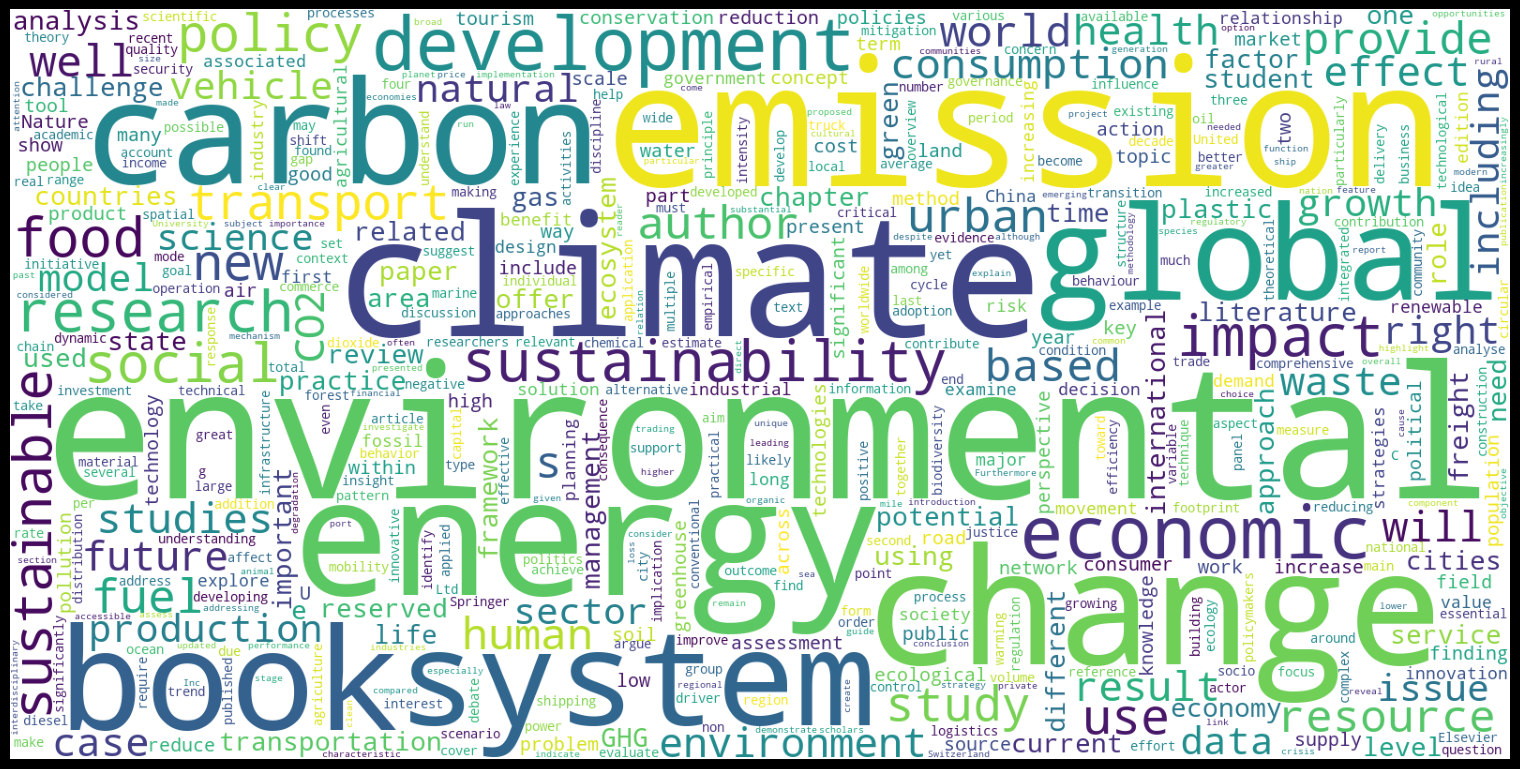

In [79]:
# WordCloud
bibfile.word_cloud_plot(entry = 'abs', size_x= 15, size_y= 10, wordsn=500)

In [80]:
# Check Table
table = PrettyTable()
data_wd = bibfile.ask_gpt_wd
table.field_names = ['Wprd', 'Importance']
for key, value in data_wd.items():
    table.add_row([key, round(value,4)])
print(table)

+-------------------+------------+
|        Wprd       | Importance |
+-------------------+------------+
|   environmental   |    1.0     |
|      emission     |   0.8933   |
|      climate      |   0.8281   |
|       energy      |   0.7866   |
|       change      |   0.7668   |
|       carbon      |   0.5988   |
|        book       |   0.585    |
|       system      |   0.5455   |
|       global      |   0.5237   |
|    development    |   0.5198   |
|      economic     |   0.5079   |
|   sustainability  |   0.502    |
|      research     |   0.4941   |
|       impact      |   0.4881   |
|        food       |   0.4466   |
|       social      |   0.4447   |
|    sustainable    |   0.4328   |
|       policy      |   0.3953   |
|        new        |   0.3854   |
|        use        |   0.3617   |
|     transport     |   0.3597   |
|       study       |   0.3518   |
|        fuel       |   0.3439   |
|       urban       |   0.3439   |
|       author      |   0.336    |
|         s         

In [81]:
# N-Grams
bibfile.get_top_ngrams(view = 'notebook', entry = 'kwp', ngrams = 3, stop_words = [], rmv_custom_words = [], wordsn = 15)

In [117]:
# Check table 
data_ng = bibfile.ask_gpt_ng
display(data_ng)

,Word,Freq
0,carbon dioxide carbon,17
1,gas emissions greenhouse,13
2,emissions greenhouse gases,13
3,life cycle assessment,10
4,economic and social,10
5,and social effects,10
6,life cycle analysis,9
7,supply chain management,9
8,dioxide carbon emission,9
9,carbon dioxide emissions,8


In [116]:
# Document Projection based on words. It returns the proejection (each document coordinate) and the lebels (each document cluster)
projection, labels = bibfile.docs_projection(view = 'notebook',
                                              corpus_type = 'abs',
                                              stop_words = ['en'],
                                              rmv_custom_words = [],
                                              custom_label = [],
                                              custom_projection = [],
                                              n_components = 2,
                                              n_clusters = 2,
                                              tf_idf = False,
                                              embeddings = False,
                                              method = 'umap')

In [84]:
# Check table
data_pr = pd.DataFrame(np.hstack([projection, labels.reshape(-1,1)]))
display(data_pr)

,0,1,2
0,-3.759803,10.559958,4.0
1,-3.523239,9.164800,1.0
2,-0.747381,5.955862,2.0
3,-3.763024,11.399499,4.0
4,8.330484,3.620365,0.0
...,...,...,...
425,-2.462118,7.257698,3.0
426,-2.862086,7.154194,3.0
427,-2.953345,5.437782,3.0
428,-1.739205,6.704123,3.0


In [85]:
bibfile.plot_evolution_year(view = 'notebook',
                            stop_words = ['en'],
                            rmv_custom_words = [],
                            key = 'abs',
                            topn = 10,
                            start = 2010,
                            end = 2024)

In [86]:
# view table
data_ep = bibfile.ask_gpt_ep
print(textwrap.fill(data_ep, 150))

 2010: environmental (6), book (5), carbon (4), frameworks (3), reserved (3), growth (3), studies (3), rights (3), major (3), issues (3) 2011: book
(6), long (4), systems (4), climate (4), science (4), change (4), energy (4), tools (3), presents (3), process (3) 2012: environmental (8), book (8),
rights (7), reserved (7), economic (6), global (6), social (5), policy (5), case (5), change (5) 2013: book (12), environmental (9), change (9),
social (9), political (9), rights (8), reserved (8), global (8), climate (8), development (8) 2014: environmental (13), book (13), global (13), change
(12), sustainability (11), studies (11), issues (10), development (10), social (10), climate (10) 2015: environmental (11), global (10), rights (9),
based (9), climate (9), policy (9), reserved (9), studies (9), systems (9), change (9) 2016: environmental (10), book (10), economic (10), development
(9), climate (8), rights (8), gas (7), reserved (7), social (7), world (7) 2017: environmental (17), book 

In [87]:
# Sankey Diagram 
bibfile.sankey_diagram(view = 'notebook', entry = ['aut', 'cout', 'inst', 'lan'], topn = 10)

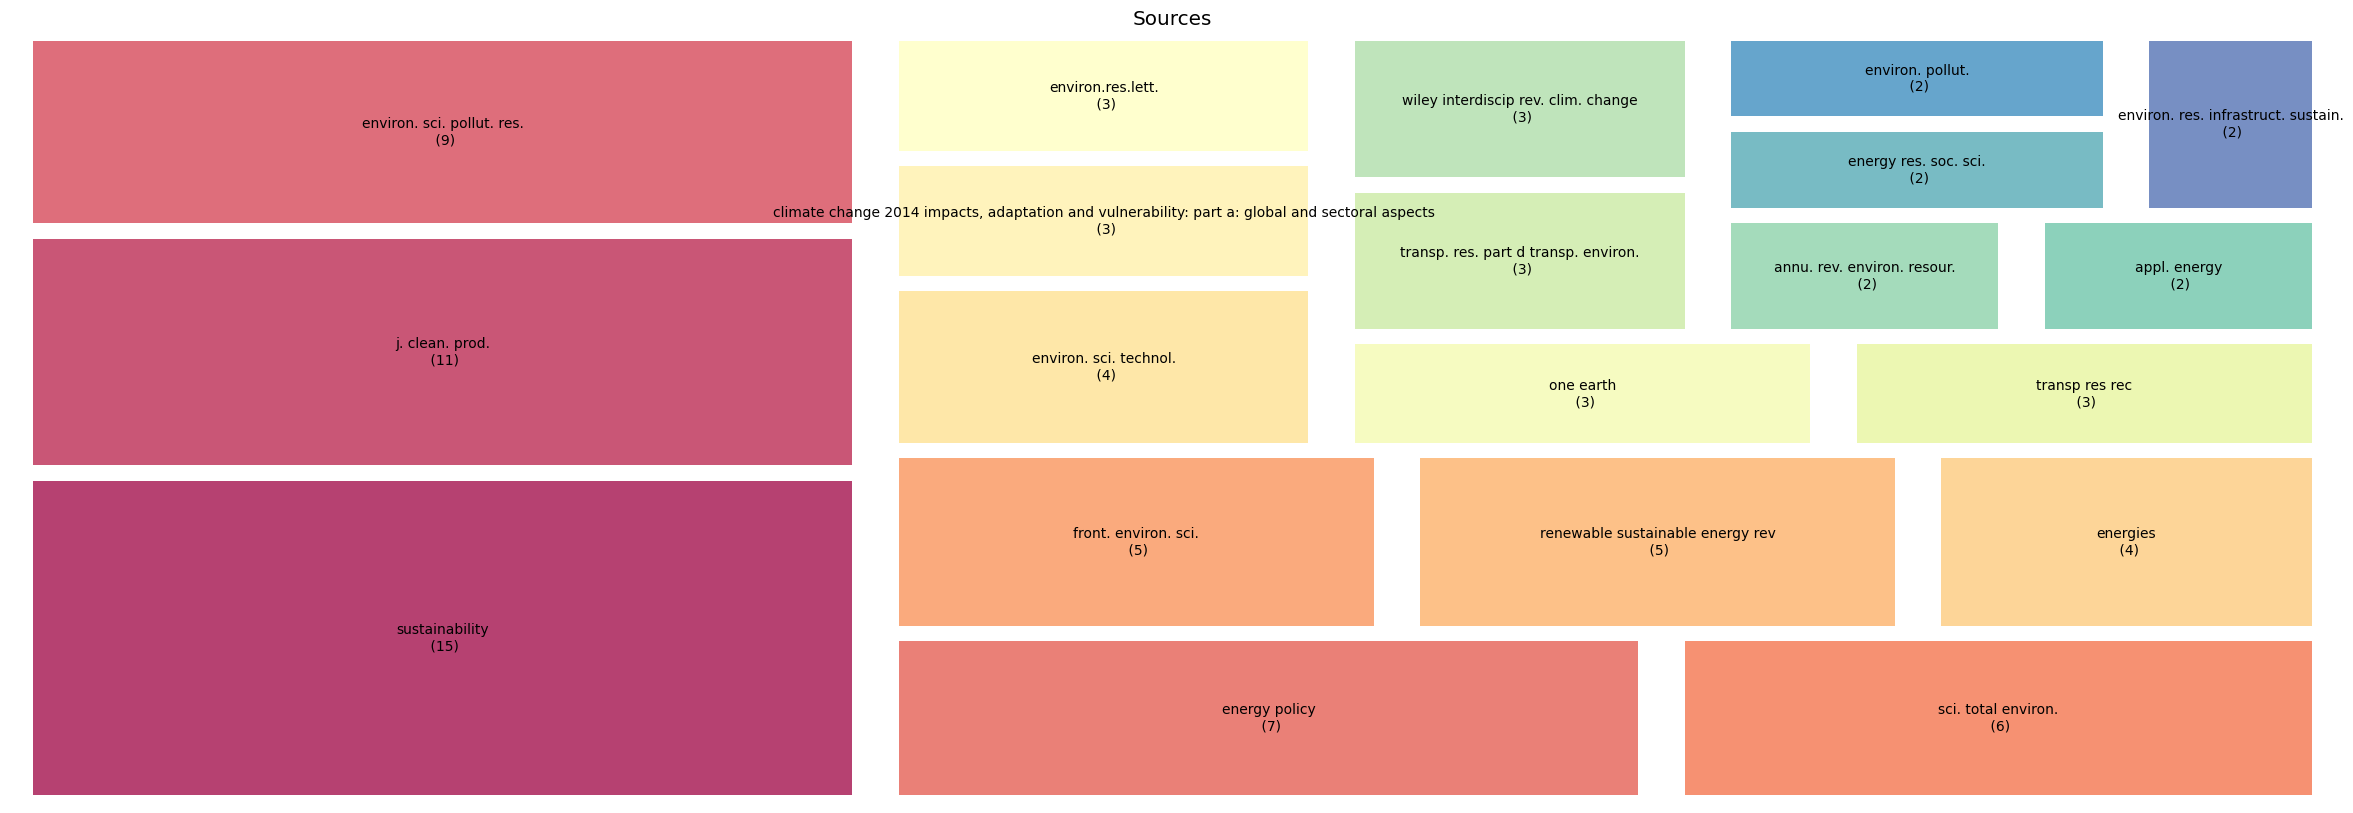

In [88]:
# Tree Map
# Arguments: entry = 'kwp', 'kwa', 'aut', 'jou', 'ctr', or 'inst';
#            topn  = Total number entities
bibfile.tree_map(entry = 'jou', topn = 20, size_x = 30, size_y = 10)

In [89]:
# Authors productivity plot. It informs for each year documents (IDs) published for each author
bibfile.authors_productivity(view = 'notebook', topn = 20)

In [90]:
# View Table
data_ap = bibfile.ask_gpt_ap
display(data_ap)

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
unknow,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0
"horvath, arpad",0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
"kuşkaya, sevda",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
"hall, c. michael",0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"taptich, michael n.",0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"steg, linda",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
"scarpellini, sabina",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
"osorio-tejada, jose luis",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
"llera-sastresa, eva",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
"carolan, michael",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


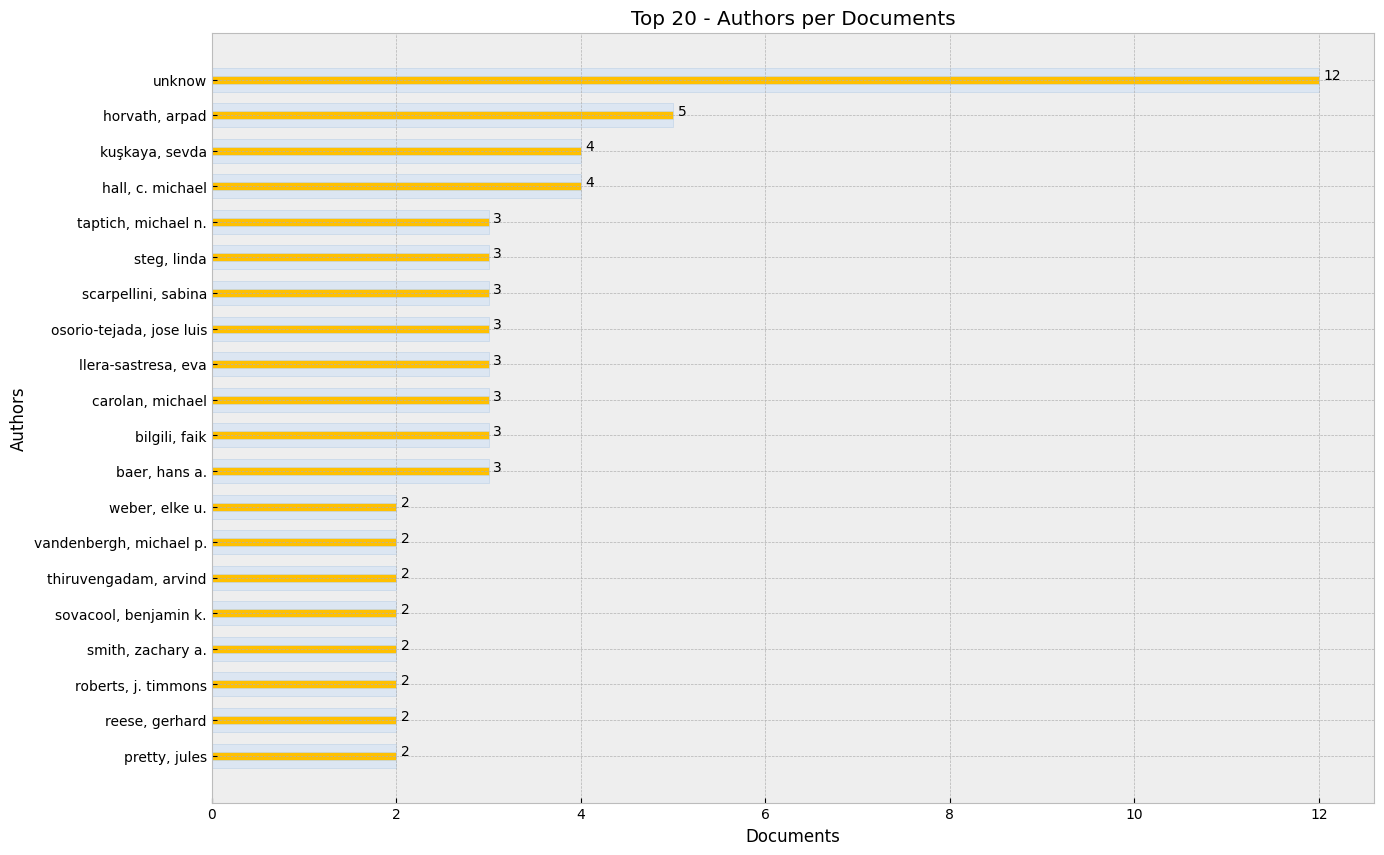

In [91]:
# Bar Plots
bibfile.plot_bars(statistic = 'apd', topn = 20, size_x = 15, size_y = 10)

In [68]:
# View Table
data_bp = bibfile.ask_gpt_bp
display(data_bp)

,Documents,Authors
0,"jaramillo, paulina",3
1,"gallachoir, brian p. o.",3
2,"axsen, jonn",3
3,"zhu, lichao",2
4,"zhou, nan",2
5,"zahraee, seyed mojib",2
6,"yi, huawei",2
7,"xue, yifeng",2
8,"wu, xuefang",2
9,"wu, tongran",2


In [95]:
# Network - Collaboration Analysis Between Authors, Countries, Intitutions Or Adjacency Analysis Between Authors' Keywords or Keywords Plus. (An interactive plot).
# Arguments: view        = 'notebook', 'browser' ('notebook' -> To plot in your prefered Notebook App. 'browser' -> To plot in your prefered browser window);
#            adj_type    = 'aut', 'cout', 'inst', 'kwa', or 'kwp'
#            min_count   = Relationship between nodes that have connected at least x times;
#            node_labels = True or False (True -> The label IDs will be displayed, False -> Only the nodes will be displayed );
#            node_size   = -1. (If node_size = -1 then the default value will be used. If node_size > 0 then this new value will be used);
#            label_type  = 'id', 'name' (Only meaningfull if node_labels = True. 'id' -> The ID will be displayed; 'name' -> The name will be displayed);
#            centrality  = 'degree', 'load', 'betw', 'close', 'eigen', 'katz', 'harmonic', or None. Color nodes according to centrality criterion
#                          'degree'   = Degree Centrality
#                          'load'     = Load Centrality
#                          'betw'     = Betweenness Centrality
#                          'close'    = Closeness Centrality
#                          'eigen'    = Eigenvector Centrality
#                          'katz'     = Katz Centrality
#                          'harmonic' = Harmonic Centrality
#                           None      = The Community Algorithm, Girvan-Newman, will be used Instead of a Centrality Criterion
bibfile.network_adj(view = 'notebook', adj_type = 'aut', min_count = 5, node_labels = True, label_type = 'name', centrality = None)

# PS: If a centrality criterion is used then the values can be obtained by the following command:  bibfile.table_centr

In [28]:
# View Table
data_adj = bibfile.ask_gpt_adj
display(data_adj)

,Node 1 (Author),Node 2 (Author),Node 1 Cluster,Node 2 Cluster
0,ID: a_515,ID: a_314,1.0,0.0
1,ID: a_358,ID: a_314,0.0,0.0
2,ID: a_682,ID: a_314,0.0,0.0
3,ID: a_746,ID: a_314,0.0,0.0
4,ID: a_301,ID: a_314,0.0,0.0
5,ID: a_314,ID: a_31,0.0,0.0


In [99]:
# Network - Highlight  Collaboration Analysis Between Authors, Countries, Intitutions Or Adjacency Analysis Between Authors' Keywords or Keywords Plus. (An interactive plot).
# Arguments: view      = 'notebook', 'browser' ('notebook' -> To plot in your prefered Notebook App. 'browser' -> To plot in your prefered browser window);
#            node_ids  = A list of IDs. Only meaningfull if label_type = 'id';
#            node_name = A list of Names. Only meaningfull iflabel_type = 'name';
#            node_only = True or False (True -> Only the Node will be Highlighted, False -> Node and its Connections will be Highlighted)
bibfile.find_nodes(node_ids = [], node_name = ['drago, carlo'], node_only = False)

In [100]:
# NLP
# Arguments: corpus_type       = 'abs', 'title', 'kwa', or 'kwp';
#            stop_words        = A list of stopwords to clean the corpus. ['ar', 'bn', 'bg', 'cs', 'en', 'fi', 'fr', 'de', 'el', 'hi', 'he', 'hu', 'it', 'ja', 'ko',  'mr', 'fa', 'pl', 'pt-br', 'ro', 'ru', 'es', 'sv', 'sk', 'zh', 'th', 'uk'];
#                                'ar' = Arabic; 'bn' = Bengali; 'bg' = Bulgarian; 'cs' = Czech; 'en' = English; 'fi' = Finnish; 'fr' = French; 'de' = German; 'el' = Greek; 'he' = Hebrew;'hi' = Hindi; 'hu' = Hungarian; 'it' = Italian;
#                                'ja' = Japanese; 'ko' = Korean; 'mr' =  Marathi; 'fa' =  Persian; 'pl' =  Polish; 'pt-br' = Potuguese-Brazilian; 'ro' = Romanian; 'ru' = Russian; 'es' =  Spanish; 'sk' = Slovak; 'sv' = Swedish;
#                                'zh' = Chinese; 'th' = Thai; 'uk' = Ukrainian
#            rmv_custom_words  = A list of custom stopwords to clean the corpus;
bibfile.create_embeddings(stop_words = ['en'], rmv_custom_words = [], corpus_type = 'abs')
emb = bibfile.embds

In [101]:
# NLP #-1 refers to all outliers and should typically be ignored.
# Arguments: stop_words  = A list of stopwords to clean the corpus. ['ar', 'bn', 'bg', 'cs', 'en', 'fi', 'fr', 'de', 'el', 'hi', 'he', 'hu', 'it', 'ja', 'ko',  'mr', 'fa', 'pl', 'pt-br', 'ro', 'ru', 'es', 'sv', 'sk', 'zh', 'th', 'uk'];
#                        'ar' = Arabic; 'bn' = Bengali; 'bg' = Bulgarian; 'cs' = Czech; 'en' = English; 'fi' = Finnish; 'fr' = French; 'de' = German; 'el' = Greek; 'he' = Hebrew;'hi' = Hindi; 'hu' = Hungarian; 'it' = Italian;
#                        'ja' = Japanese; 'ko' = Korean; 'mr' =  Marathi; 'fa' =  Persian; 'pl' =  Polish; 'pt-br' = Potuguese-Brazilian; 'ro' = Romanian; 'ru' = Russian; 'es' =  Spanish; 'sk' = Slovak; 'sv' = Swedish;
#                        'zh' = Chinese; 'th' = Thai; 'uk' = Ukrainian
#            rmv_custom_words  = A list of custom stopwords to clean the corpus;
#            embeddings        = True or False. If True then word embeddings are used to create the topics
bibfile.topics_creation(stop_words = ['en'], rmv_custom_words = [], embeddings = False)

   Topic  Count                                      Name  \
0      0    415  0_environmental_climate_energy_emissions   
1      1     15       1_unknow_knowledge_carrillo_society   

                                      Representation  \
0  [environmental, climate, energy, emissions, ch...   
1  [unknow, knowledge, carrillo, society, economy...   

                                 Representative_Docs  
0  [anthropogenic climate change globally recogni...  
1                           [unknow, unknow, unknow]  


In [102]:
# NLP
# Each document Topic
topics = bibfile.topics

In [103]:
# NLP
# Each document Probability to belong a Topic
probs = bibfile.probs

In [107]:
# NLP
# Arguments: view = 'notebook', 'browser' ('notebook' -> To plot in your prefered Notebook App. 'browser' -> To plot in your prefered browser window)
bibfile.graph_topics_distribution(view = 'notebook')

In [108]:
# NLP
# Arguments: view = 'notebook', 'browser' ('notebook' -> To plot in your prefered Notebook App. 'browser' -> To plot in your prefered browser window)
bibfile.graph_topics(view = 'notebook')

In [109]:
# NLP
# Arguments: view = 'notebook', 'browser' ('notebook' -> To plot in your prefered Notebook App. 'browser' -> To plot in your prefered browser window)
bibfile.graph_topics_projection(view = 'notebook')

In [110]:
# NLP
# Arguments: view = 'notebook', 'browser' ('notebook' -> To plot in your prefered Notebook App. 'browser' -> To plot in your prefered browser window)
bibfile.graph_topics_heatmap(view = 'notebook')

In [111]:
# NLP
bibfile.topics_representatives()

,Topic,Docs
0,0.0,132; 395; 425
1,1.0,4; 4; 4


In [112]:
# NLP
similar_topics, similarity = bibfile.topic_model.find_topics('electre', top_n = 10)
for i in range(0, len(similar_topics)):
  print('Topic: ', similar_topics[i], 'Correlation: ', round(similarity[i], 3))

Topic:  1 Correlation:  0.206
Topic:  0 Correlation:  0.116


In [113]:
# NLP
bibfile.topic_model.save('my_topic_model')
#loaded_topic_model = BERTopic.load('my_topic_model')

2024-01-24 16:41:15,511 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [114]:
# NLP - Abstractive Summarization
# Arguments: article_ids = A list of documents to perform an abstractive summarization with the available abstracts. If the list is empty then all documents will be used
#            model_name  = Available pre-trained models. Complete list is available at  https://huggingface.co/models?pipeline_tag=summarization&sort=downloads&search=pegasus
abs_summary = bibfile.summarize_abst_peg(article_ids = [233, 164, 180], model_name = 'google/pegasus-xsum')


Total Number of Valid Abstracts:  3



Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
# NLP - Check Abstractive Summarization
print(textwrap.fill(abs_summary, 150))

Hans Baer's The Australian Capitalism and the Climate Change Movement looks at Australia's climate politics at the margins, namely the Greens, the
labour union, the environmental NGOs, and the grass-roots climate movement.Drawing upon both archival and ethnographic research, Hans Baer examines
Australian climate politics at the margins, namely the Greens, the labour union, the environmental NGOs, and the grass-roots climate movement.Adopting
a climate justice perspective which calls for "system change, not climate change" as opposed to the Greens.
